<a href="https://colab.research.google.com/github/amalvarezme/ProcesoDigitalSen/blob/master/EEG_BCI_MI/ProyectoFinalPDS_20201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control de juego por emulador de nintendo utilizando registros de EEG

En se cuaderno se presentan las etapas principales para el control de un videojuego utilizando imaginación motora desde registros de electroencefalografía. Los pasos principales incluyen:

1. Representación de series de tiempo multi-canal EEG utilizando espectro en frecuencia, wavelets y proyecciones basadas en varianza.

2. Codificación de espacios utilizando momentos estadísticos.

3. Detección de intención de movimiento utilizando clasificador de Bayes y clasificador bosques aleatorios.

4. Manipular emulador desde control del teclado utilizando Python.

5. Visualizar canales y bandas de frecuencia relevantes para la detección  (interpretabilidad - Por qué funciona?)

Se probará en la base de datos [BCI competition 4_2a](https://github.com/amalvarezme/ProcesoDigitalSen/blob/master/EEG_BCI_MI/Description_desc_2a.pdf).

###  1. Representación de señales

Se cargan los archivos .gdf de un par de sujetos de interés y se instala el paquete [MNE](https://mne.tools/stable/index.html) para la manipulación de registros EEG.

In [1]:
# Cargar base de datos
#id del archivo: 1sui-FJI5znNJuQOk0whM6PALI89XfKss
FILEID = "1sui-FJI5znNJuQOk0whM6PALI89XfKss"
#1sui-FJI5znNJuQOk0whM6PALI89XfKss
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir
!pip install mne==0.19

--2021-12-11 17:20:00--  https://docs.google.com/uc?export=download&confirm=KLXd&id=1sui-FJI5znNJuQOk0whM6PALI89XfKss
Resolving docs.google.com (docs.google.com)... 172.217.164.142, 2607:f8b0:4004:836::200e
Connecting to docs.google.com (docs.google.com)|172.217.164.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-7k-docs.googleusercontent.com/docs/securesc/b8j0pfgaq5vh428mcbobbj33pkf8he53/11t4mgeg81llau3mi66kesfdvg1oiurg/1639243200000/09173029842254050324/17921573341611306298Z/1sui-FJI5znNJuQOk0whM6PALI89XfKss?e=download [following]
--2021-12-11 17:20:00--  https://doc-04-7k-docs.googleusercontent.com/docs/securesc/b8j0pfgaq5vh428mcbobbj33pkf8he53/11t4mgeg81llau3mi66kesfdvg1oiurg/1639243200000/09173029842254050324/17921573341611306298Z/1sui-FJI5znNJuQOk0whM6PALI89XfKss?e=download
Resolving doc-04-7k-docs.googleusercontent.com (doc-04-7k-docs.googleusercontent.com)... 172.217.1.193, 2607:f8b0:4004:801::2001
Connecting to doc-

In [2]:
#importar paquetes
#importar carpeta con funciones
import sys
#agregar carpeta con funciones
sys.path.insert(1, './CodesBCIITL')
%matplotlib inline
from MIfunctions import * #importar todas las funciones de manejo de eeg con mne

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter, welch, lfilter_zi, stft #, freqz
import numpy as np
from mne.io import read_raw_edf
from mne.decoding import CSP
import pandas as pd
import json as  js #conda install -c jmcmurray json
import warnings
import seaborn as sns
import mne

from numpy import matlib
import os
from matplotlib.animation import FuncAnimation
from ipywidgets import interact

import cv2 

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne import Epochs, pick_types, events_from_annotations

#crear carpeta con resultados
from google.colab import files
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import shutil
from datetime import date, datetime

In [3]:
#cargar datos
#Descripcion base de datos
#https://drive.google.com/file/d/1354HvKfp8sMckvN2t3SR9OUo9Z0yE9Uv/view?usp=sharing

sbj = 9 #sujeto facil s03, sujeto dificil s02
name = './CodesBCIITL/data/A0' + str(sbj)
filename_train = name+'T.gdf'
Ch = np.arange(0,22)# lectura canales eeg
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
clases = [769,770] # clases izquierda y derecha -> extender a pies y lengua
vt = [-1.5,3.5] #escoger ventana de analisis : -li:lf desde el estimulo cue # probar con ventana de 1 seg
#vt = [1.5,0.5] #escoger ventana de analisis : -li:lf desde el estimulo cue # probar con ventana de 1 seg
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
i_muestras, i_clases, raw, Xraw, y, ni,m = leer_bci42a_train_full(filename_train,clases,Ch,vt)
fs = raw.info['sfreq'] #frecuencia de muestreo
print(fs)


Extracting EDF parameters from /content/CodesBCIITL/data/A09T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
250.0


- Se presenta la frecuencia de muestreo y el arreglo en epochs, canales y muestras en tiempo, con el respectivo vector de etiquetas

In [4]:
print(Xraw.shape) # epoch (trials) x ch x #muestras
print(y.shape)#vector de etiquetas
np.unique(y)

(116, 22, 500)
(116,)


array([1., 2.])

- Se gráfica un intento/epoch del EEG:

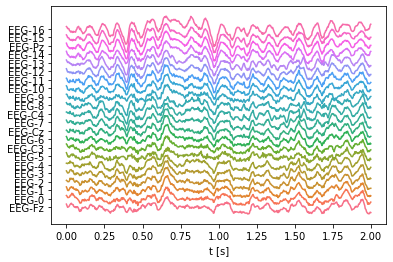

In [5]:
#eeg original trial i
i = 1
plot_eeg(data=Xraw[i],sample_rate=fs,channels_names=[raw.ch_names[i] for i in Ch])
plt.xlabel('t [s]')
plt.savefig('results/EEGOriginal.pdf', dpi=300)


- Se presenta también el arreglo completo de datos de toda la sesión:

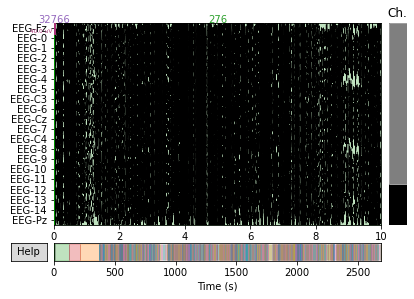

<RawGDF  |  A09T.gdf, n_channels x n_times : 25 x 673328 (2693.3 sec), ~54 kB, data not loaded>


In [6]:
f = raw.plot() # 137 intentos, 22 canales, 625= 2.5*250: #muestras
f.savefig('results/EEGcompleto.pdf', dpi=300)
#Xraw[0]
print(raw)

## Representación por Fourier - FFT

- Se cálcula la FFT a lo largo de las muestras en el tiempo para todos los canales y todas las epochs.


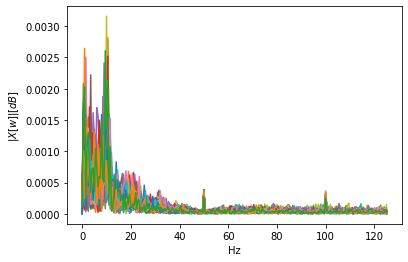

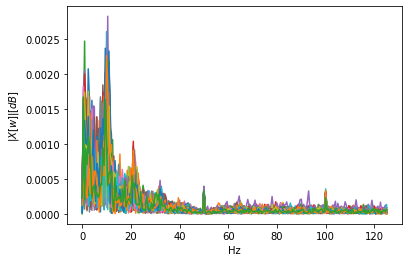

(116, 22, 251)

In [7]:
# fft por muestras eje = axis = 2
Xrfft = abs(np.fft.rfft(Xraw,axis=2)) # matriz 1 de atributos segun fft
vf = np.fft.rfftfreq(Xraw.shape[2],1/fs)  # pasar eje x a Hz segun  numero de puntos y periodo muestreo
Xrfft.shape
#graficar espectro trials en clase 1 / mano izquierda
plt.plot(vf,Xrfft[y==1,11,:].T)
plt.xlabel('Hz')
plt.ylabel('$|X[w]| [dB]$')
plt.savefig('results/Ejfft.pdf', dpi=300)
plt.show()

#graficar espectro trials en clase 2 / mano derecha
plt.plot(vf,Xrfft[y==2,11,:].T)
plt.xlabel('Hz')
plt.ylabel('$|X[w]| [dB]$')
plt.show()
Xrfft.shape

NOTA: nos interesa la información en los [ritmos cerebrales](https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/brain-waves) $\alpha\in[8,12] Hz$; $\beta\in[12,30] Hz$ para imaginación de movimiento

## Representación por STFT:

- Se realiza una representación en tiempo corto con STFT:

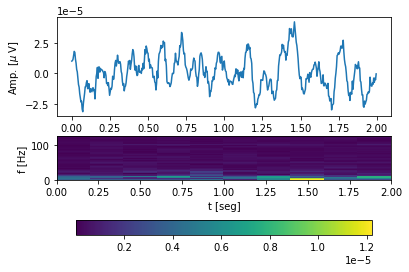

In [36]:
#estimar stft con ventanas de nperseg puntos sobre eje temporal
f,t,Xstft = stft(Xraw,fs=fs,nperseg=100,axis=2)
Xstft = abs(Xstft)

#graficar stft para un trial y un canal
trail = 0
chi = 11

fig, ax = plt.subplots(2, 1)
vt = np.arange(0,Xraw.shape[2]/fs,1/fs)
ax[0].plot(vt,Xraw[trail,chi,:])
ax[0].set_ylabel("Amp. [$\mu$ V]")
im = ax[1].pcolormesh(t, f, Xstft[trail,chi])
fig.colorbar(im, ax=ax[1],orientation="horizontal",pad=0.4)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
plt.savefig('results/stft.pdf', dpi=300)


In [37]:
print(Xstft.shape) #epocas, Ch, puntos en frecuencia, #ventanas
print(f)
print(t)

(116, 22, 51, 11)
[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125. ]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


## Representación tiempo escala con Wavelets - cwt

- Se cálcula la representación en tiempo-escala utilizando wavelets:



In [38]:
import pywt 
#w = pywt.Wavelet('db4')
#calcaluar representacion wavelet con complex morlet
Xcwt,freq =pywt.cwt(Xraw,np.arange(1,50),'cmor',1/fs,axis=2)
#redistribuir ejes a trials, canales y pesos wavelet
Xcwt = abs(np.transpose(Xcwt,[1,2,0,3]))
Xcwt.shape

(116, 22, 49, 500)

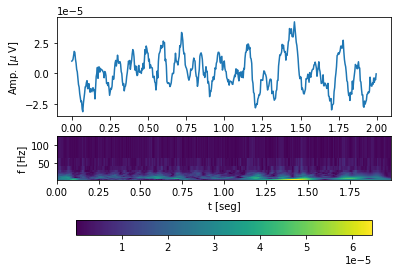

In [11]:
fig, ax = plt.subplots(2, 1)
vt = np.arange(0,Xraw.shape[2]/fs,1/fs)
ax[0].plot(vt,Xraw[trail,chi,:])
ax[0].set_ylabel("Amp. [$\mu$ V]")
im = ax[1].pcolormesh(vt, freq, (Xcwt[trail,chi]))
fig.colorbar(im, ax=ax[1],orientation="horizontal",pad=0.4)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')

plt.savefig('results/cwt_cmor.pdf', dpi=300)



# Representación por PSD

(116, 22, 76)


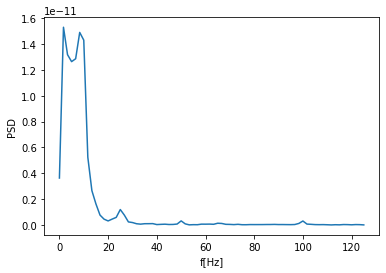

In [39]:
#calculo psd po metodo welch con nperseg muestras por ventana
fpsd, Xpsd = welch(Xraw, fs=fs, nperseg=150,axis=2)
print(Xpsd.shape)
fpsd
plt.plot(fpsd,Xpsd[trail,chi,:])
plt.xlabel('f[Hz]')
plt.ylabel('PSD')
plt.show()
#plt.savefig('results/psd.pdf', dpi=300)

In [16]:
fpsd

array([  0.        ,   1.66666667,   3.33333333,   5.        ,
         6.66666667,   8.33333333,  10.        ,  11.66666667,
        13.33333333,  15.        ,  16.66666667,  18.33333333,
        20.        ,  21.66666667,  23.33333333,  25.        ,
        26.66666667,  28.33333333,  30.        ,  31.66666667,
        33.33333333,  35.        ,  36.66666667,  38.33333333,
        40.        ,  41.66666667,  43.33333333,  45.        ,
        46.66666667,  48.33333333,  50.        ,  51.66666667,
        53.33333333,  55.        ,  56.66666667,  58.33333333,
        60.        ,  61.66666667,  63.33333333,  65.        ,
        66.66666667,  68.33333333,  70.        ,  71.66666667,
        73.33333333,  75.        ,  76.66666667,  78.33333333,
        80.        ,  81.66666667,  83.33333333,  85.        ,
        86.66666667,  88.33333333,  90.        ,  91.66666667,
        93.33333333,  95.        ,  96.66666667,  98.33333333,
       100.        , 101.66666667, 103.33333333, 105.  

## 2. Codificar representación utilizando momentos estadísticos

- Se codifica por momentos sobre los ritmos $\alpha$ y $\beta$ # las representaciones por fft, psd, stft y cwt, respecto a la cantidad de puntos obtenidos

- Se utiliza el operador de media, mediana, varianza, máximo y mínimo.



In [40]:
def cal_momentos(Xf): #se calcula momentos sobre ultimo eje del arreglo
  #media, mediana, var, max, min
  m =np.c_[(Xf.mean(axis=-1),np.median(Xf,axis=-1),Xf.var(axis=-1),Xf.max(axis=-1),Xf.min(axis=-1))]
  return m

In [18]:
#funcion para representacion por momentos
def representacion_(Xraw,banda1=[8,12],banda2=[12,30],fs=250,
                    nperseg_stft=100,scale_cwt=np.arange(1,50),nperseg_psd=150): #Xraw: trials, Ch, Tm
    trials,Ch,Tm = Xraw.shape #tamaño del arreglo
    #calculo fourier
    Xrfft = abs(np.fft.rfft(Xraw,axis=2)) # matriz 1 de atributos segun fft
    vf_fft = np.fft.rfftfreq(Xraw.shape[2],1/fs) 
    #calculo stft
    vf_stft,_,Xstft = stft(Xraw,fs=fs,nperseg=nperseg_stft,axis=2)
    Xstft = abs(Xstft)
    #calculo cwt
    Xcwt,vf_cwt =pywt.cwt(Xraw,scale_cwt,'cmor',1/fs,axis=2)
    Xcwt = abs(np.transpose(Xcwt,[1,2,0,3]))
    #calculo psd
    vf_psd, Xpsd = welch(Xraw, fs=fs, nperseg=nperseg_psd,axis=2)

    ###concatenar por canales e intentos los momentos de stft y cwt en alpha y beta
    ### concatenar por canalues  e intentos los valores de fft y psd en  alpha y beta
    ind_fft_b1 = (vf_fft >= banda1[0]) & (vf_fft<=banda1[1])
    ind_fft_b2 = (vf_fft >= banda2[0]) & (vf_fft<=banda2[1])
    ind_stft_b1 = (vf_stft >= banda1[0]) & (vf_stft<=banda1[1])
    ind_stft_b2 = (vf_stft >= banda2[0]) & (vf_stft<=banda2[1])
    ind_cwt_b1 = (vf_cwt >= banda1[0]) & (vf_cwt<=banda1[1])
    ind_cwt_b2 = (vf_cwt >= banda2[0]) & (vf_cwt<=banda2[1])
    ind_psd_b1 = (vf_psd >= banda1[0]) & (vf_psd<=banda1[1])
    ind_psd_b2 = (vf_psd >= banda2[0]) & (vf_psd<=banda2[1])
    #valores de fft, momentos stft, momentos cwt, valores psd
    Fb1 = np.c_[(Xrfft[:,:,ind_fft_b1].reshape(trials,-1),
                 cal_momentos(Xstft[:,:,ind_stft_b1,:].reshape(trials,Ch,-1)).reshape(trials,-1),
                cal_momentos(Xcwt[:,:,ind_cwt_b1,:].reshape(trials,Ch,-1)).reshape(trials,-1), 
                 Xpsd[:,:,ind_psd_b1].reshape(trials,-1))]
    #momentos fft, momentos stft, momentos cwt, valores psd
    Fb2 = np.c_[(cal_momentos(Xrfft[:,:,ind_fft_b2]).reshape(trials,-1),
                cal_momentos(Xstft[:,:,ind_stft_b2,:].reshape(trials,Ch,-1)).reshape(trials,-1),
                cal_momentos(Xcwt[:,:,ind_cwt_b2,:].reshape(trials,Ch,-1)).reshape(trials,-1), 
                 Xpsd[:,:,ind_psd_b2].reshape(trials,-1))]

    tam = [np.array([sum(ind_fft_b1),5,5,sum(ind_psd_b1)]),np.array([5,5,5,sum(ind_psd_b2)])]

    return Fb1,Fb2,tam # Rep [trials,P]; P = #Ch, #bandas=2, #mommentos por cwt y stft, #valores psd y fft


In [19]:
Fb1,Fb2,tam = representacion_(Xraw)
Xdata_rep = np.c_[(Fb1,Fb2)]

In [41]:
print(tam)
print(Fb1.shape) #arreglo sobre banda alpha
print(Fb2.shape) # arreglo sobre banda beta
print(Xdata_rep.shape) #arreglo concatenado

[array([9, 5, 5, 3]), array([ 5,  5,  5, 11])]
(116, 484)
(116, 572)
(116, 1056)


## Filtrado digital y espectral generalizado

- Se requiere de representaciones por bancos de filtros para utilizar caracterizaciones específicas en imaginación motora.

- Se utilizan filtros IIR según lo estudiado en el cuaderno de [Transformada Z y filtros digitales](https://github.com/amalvarezme/ProcesoDigitalSen/blob/master/PDS_Notebooks/4_nonrecursive_filters/1_Respaso_TransformadaZ_Filtros.ipynb).

NOTA: se sugiere evaluar los filtros digitales con la función [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) que compenza el retardo de fase.

- A continuación se presenta un ejemplo de filtrado digital sobre un registro de EEG.

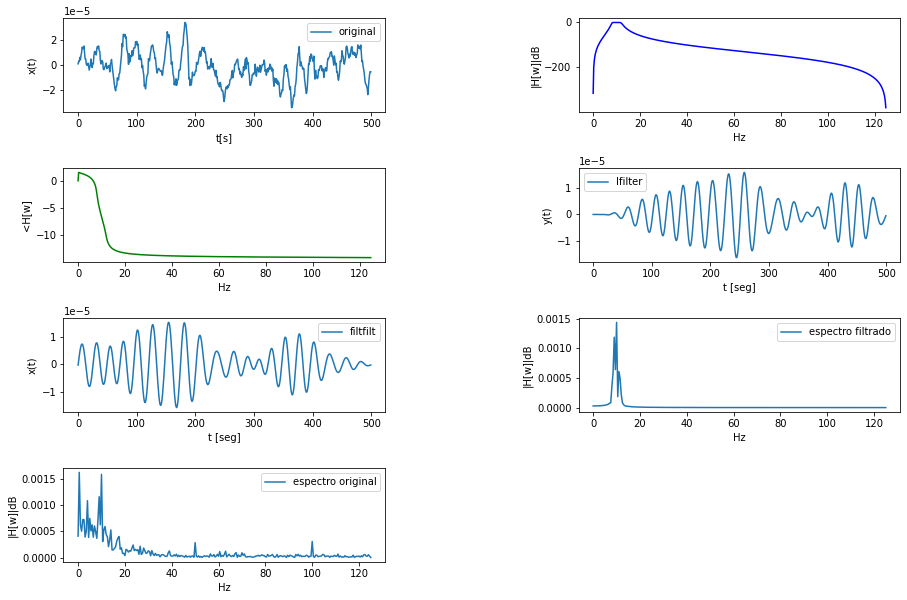

In [46]:
# Filtro pasabanda según ritmos cerebrales
#filtro butterworth
#filtfilt y lfilter
from scipy import signal
trial = 0 #num trial
ch = 11 #num canal
data = Xraw[trial,ch,:] #trial, ch, muestras

plt.figure(figsize=(15,10))
plt.subplot(421)
plt.plot(data,label='original')
plt.xlabel('t[s]')
plt.ylabel('x(t)')
plt.legend()

#diseñar filtro
lowcut = 8 #frecuencia corte 1
highcut = 12 #frecuencia corte 2
order = 5 #orden del filtro
b, a = butter_bandpass(lowcut, highcut, fs, order=order)#diseño filtro pasabanda
w, h = signal.freqz(b,a,fs=fs) #respuesta en frecuencia del filtro
#graficar magnitud
plt.subplot(422)
plt.plot(w, 20 * np.log10(abs(h)), 'b')
#plt.plot(w, abs(h), 'b')
plt.xlabel('Hz')
plt.ylabel('|H[w]|dB')

#graficar fase
angles = np.unwrap(np.angle(h))
plt.subplot(423)
plt.plot(w, angles, 'g')
plt.xlabel('Hz')
plt.ylabel('<H[w]')

#señales filtrada con lfilter - no compenza retardo en fase
plt.subplot(424)
yy = signal.lfilter(b, a, data)
plt.plot(yy,label='lfilter')
plt.xlabel('t [seg]')
plt.ylabel('y(t)')
plt.legend()

#filtar con filtfilt - si compenza el retardo de fase
plt.subplot(425)
yy = signal.filtfilt(b,a,data)
plt.plot(yy,label='filtfilt')
plt.xlabel('t [seg]')
plt.ylabel('x(t)')
plt.legend()

#espectro señal fitlrada
plt.subplot(426)
Yw = np.fft.rfft(yy)
fv = np.fft.rfftfreq(yy.shape[0],1/fs)
plt.plot(fv,abs(Yw),label='espectro filtrado')
plt.xlabel('Hz')
plt.ylabel('|H[w]|dB')
plt.legend()

#espectro original
plt.subplot(427)
Yo = np.fft.rfft(data)
fv = np.fft.rfftfreq(data.shape[0],1/fs)
plt.plot(fv,abs(Yo),label='espectro original')
plt.xlabel('Hz')
plt.ylabel('|H[w]|dB')
plt.legend()
plt.subplots_adjust(hspace=0.6,wspace=0.6)
plt.show()

- Recuerde que el filtrado también se puede realizar mediante la reconstrucción del espectro de Fourier, utilizando solo los armónicos de interés:

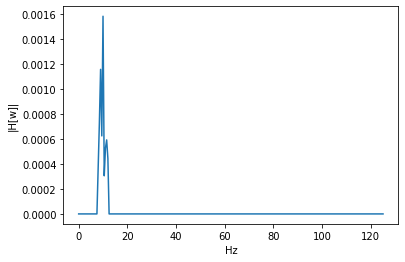

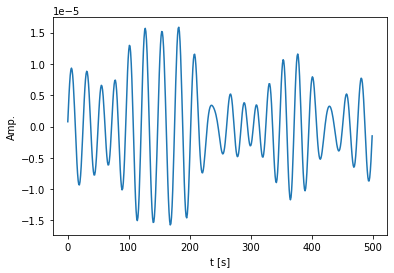

In [22]:
ind = (fv >= lowcut ) & (fv <= highcut) #determinar armónicos de interés
Yo2 = Yo
Yo[~ind] = 0 #colocar en 0 armónicos fuera de la banda de interés
xef = np.fft.irfft(Yo)

plt.plot(fv, abs(Yo))
plt.xlabel('Hz')
plt.ylabel('|H[w]|')
plt.show()
plt.plot(xef)
plt.xlabel('t [s]')
plt.ylabel('Amp.')
plt.show()


- No obstante, filtrar con Fourier requiere calcular la transformada de la señal de entrada, mientras que la evaluación del filtro digital solo require operar la convolución entre la señal y los pesos aprendidos en el diseño.

# Caracterización mediante patrones espaciales comunes: Common Spatial Patterns

Para información detallada ver [Slides](https://es.slideshare.net/yokotatsuya/introduction-to-common-spatial-pattern-filters-for-eeg-motor-imagery-classification)

In [23]:
#https://en.wikipedia.org/wiki/Neural_oscillation
#ver funcionamiento caracterizacion de common spatial patterns -> especial para motor imagery
#https://en.wikipedia.org/wiki/Common_spatial_pattern
#https://es.slideshare.net/yokotatsuya/introduction-to-common-spatial-pattern-filters-for-eeg-motor-imagery-classification
f_frec = np.array([[8,12],[12,30]]) #arreglo con bandas de interes alpha y beta
csp = CSP_epochs_filter_extractor(fs=fs,f_frec=f_frec,ncomp = Xraw.shape[1],reg='empirical') #contruir modelo csp
Xdata_csp = csp.fit_transform(Xraw,y) #encontrar canales rotados con csp
print(Xraw.shape,Xdata_csp.shape)


(116, 22, 500) (116, 44)


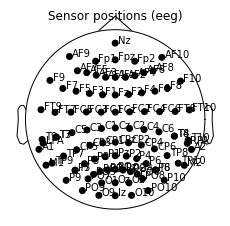

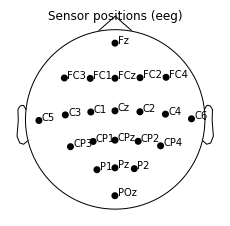

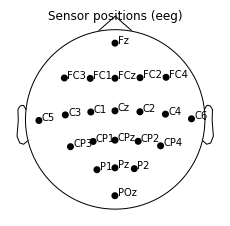

In [24]:
#se deben ajustar los nombres de los canales al montaje 10-20 de mne
montage = mne.channels.read_montage('standard_1020') #"standard_1020"
#montage = mne.channels.make_standard_montage(kind='biosemi64')
info = mne.create_info(montage.ch_names, sfreq=250, ch_types="eeg",
                           montage=montage)
f,ax = plt.subplots(1,1,figsize=(3,3))
mne.viz.plot_sensors(info, show_names=True,axes=ax)
plt.show()
#canales base de datos - Se deben ajustar para las pruebas con OPENBCI
channels_names = ['Fz','FC3','FC1','FCz','FC2','FC4',
                 'C5','C3','C1','Cz','C2','C4','C6',
                 'CP3','CP1','CPz','CP2','CP4',
                  'P1','Pz','P2',
                   'POz']
# Se crea un objeto mne con el montaje de los electrodos usados
montage = mne.channels.read_montage('standard_1020', channels_names)
info = mne.create_info(channels_names, sfreq=250, ch_types="eeg",
                           montage=montage)
f,ax = plt.subplots(1,1,figsize=(3,3))
mne.viz.plot_sensors(info, show_names=True,axes=ax)
#f.savefig('results/MontageBCI42a.pdf', dpi=300)

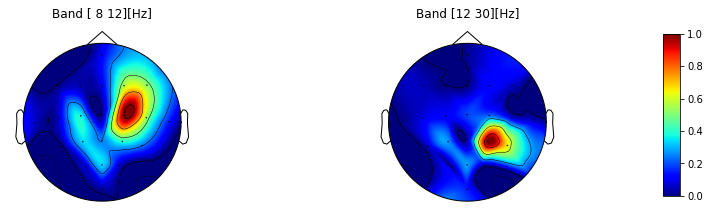

In [25]:

#visualizar en topoplot (grafica sobre sensores), canales con mas peso por representacion por bandas desde csp
f, ax = plt.subplots(1,len(csp.csp_l),figsize=(12,3))
rhov = np.zeros((csp.csp_l[0].filters_.shape[1],len(csp.csp_l)))
cmap = 'jet'
for i in range(len(csp.csp_l)):
    #rhov[:,i] = np.mean(abs(csp.csp_l[i].filters_),axis=0) #promediar pesos sobre representacion de csp
    rhov[:,i] = abs(csp.csp_l[i].filters_[0]) #promediar pesos sobre representacion de csp
    rhov[:,i] = rhov[:,i]/max(rhov[:,i])
    mne.viz.plot_topomap(rhov[:,i], info, axes=ax[i], show=False,cmap=cmap)
    ax[i].set_title('Band '+str(f_frec[i])+'[Hz]')
 
cax = f.add_axes([0.95, 0.15, 0.02, 0.75])
norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cax)
#plt.savefig('results/Relevancia_CSPFilters_0.pdf', dpi=300)
plt.show()

In [26]:
csp.csp_l[0].filters_.shape

(22, 22)

In [27]:
#matriz de representación final: concatenacion representacion por fft, psd, stft, cwt + csp
Xdata = np.c_[(Xdata_rep,Xdata_csp)]
print(Xdata_rep.shape)
print(Xdata_csp.shape)
print(Xdata.shape)

(116, 1056)
(116, 44)
(116, 1100)


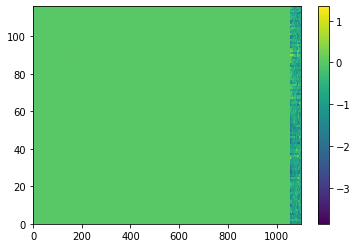

In [28]:
#graficar matriz de caracteristicas
plt.pcolormesh(Xdata)
plt.colorbar()
plt.show()

# Entrenar modelo de detección mediante bosques aleatorios

Ver [cuaderno bosques aleatorios](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_DeteccionClasificacionGH/03S_7_ArbolesDecision.ipynb)

In [29]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_predict

steps = [('scaler',StandardScaler()), # se reailiza normalización de datos para asegurar estabilidad en las representaciones
         ('cla', RandomForestClassifier())] #deteccion por bosques aleatorios

model = Pipeline(steps) #se crea modelo completo de entrenamiento        
ye = cross_val_predict(model,Xdata,y,cv=10,verbose = 50) #validación cruzada - rotacion de datos para estimar la robustes del modelo



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


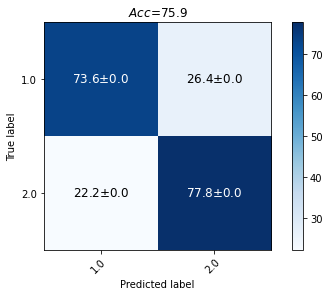

In [30]:
cm = confusion_matrix(y, ye) # matriz de confusion del modelo -> caso ideal  matriz diagonal en 100 %
cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
acc = accuracy_score(y,ye) #acierto del modelo - > caso ideal 100 %
plot_confusion_matrix_MS(cm, np.zeros(cm.shape), np.unique(y))
plt.title('${Acc}$='+ format(100*acc,'.1f') )
plt.show()

Se analiza la importancia de cada medida en Xdata

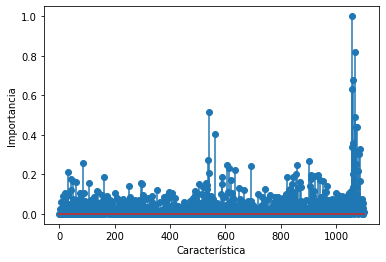

(116, 1100)


In [31]:
model.fit(Xdata,y) #revisar importancia de las caracteristicas
rho = model['cla'].feature_importances_
rho /=rho.max()
plt.stem(rho)
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.show()
print(Xdata.shape)

In [32]:
# guardar con joblib
from joblib import dump, load
savedata = {
        'cm':cm,
        'rho': rho,
        'model':model,        
          } 
dump(savedata,'modeleeg.joblib')

model_load = load('modeleeg.joblib')



# Ejercicio para el proyecto: 

Se debe construir una función que reciba un arreglo eeg de un trial, canales por tiempo, y devuelva un vector con las características más importantes encontradas

# Código para manipular teclado desde python:


*   Los siguientes comandos deben ejecutarse en una máquina local dado que Google Colab no da permisos para manipular el teclado del servidor de Google.


In [33]:
#!pip install pynput

In [34]:
'''
from pynput.keyboard import Controller #Key
import time
left = 'a'
right = 'd'
tmax = 1
keyboard = Controller()
ii = 0

while ii < nepochs: #while true or input = xxxx
    print('epoch %d/%d\n'% (ii+1,nepochs))
        
    y_pro = model.predict(Xdata[ii,:,:].reshape(1,-1)) # Xraw debe incluir representacion
    
    if (y_pro == 1):
        keyboard.press(left)
        print('%s__epoch:%d' % (left,ii+1))
        time.sleep(tmax)
        keyboard.release(left)
                   
    elif (y_pro == 2):   
        keyboard.press(right)
        print('%s__epoch:%d' % (right,ii+1))
        time.sleep(tmax)
        keyboard.release(right)
        
    ii+=1  
#%%
'''


"\nfrom pynput.keyboard import Controller #Key\nimport time\nleft = 'a'\nright = 'd'\ntmax = 1\nkeyboard = Controller()\nii = 0\n\nwhile ii < nepochs: #while true or input = xxxx\n    print('epoch %d/%d\n'% (ii+1,nepochs))\n        \n    y_pro = model.predict(Xdata[ii,:,:].reshape(1,-1)) # Xraw debe incluir representacion\n    \n    if (y_pro == 1):\n        keyboard.press(left)\n        print('%s__epoch:%d' % (left,ii+1))\n        time.sleep(tmax)\n        keyboard.release(left)\n                   \n    elif (y_pro == 2):   \n        keyboard.press(right)\n        print('%s__epoch:%d' % (right,ii+1))\n        time.sleep(tmax)\n        keyboard.release(right)\n        \n    ii+=1  \n#%%\n"

In [35]:
#model_load['model'].predict(Xnew)